In [33]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt
import os
import PIL
import pathlib

In [34]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [35]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


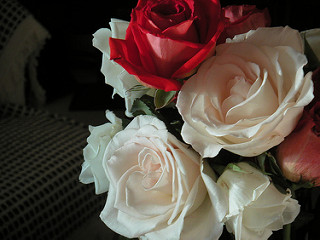

In [36]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

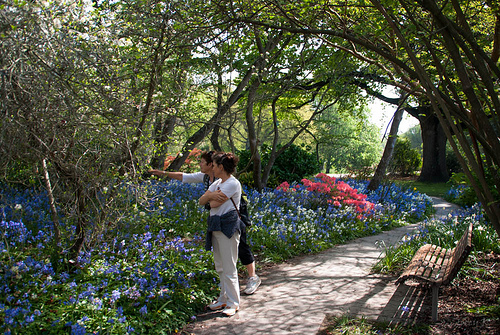

In [37]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

In [38]:
batch_size = 32
img_height = 180
img_width = 180

num_classes = 5
epochs = 15

## Dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=11,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=11,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [41]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualization

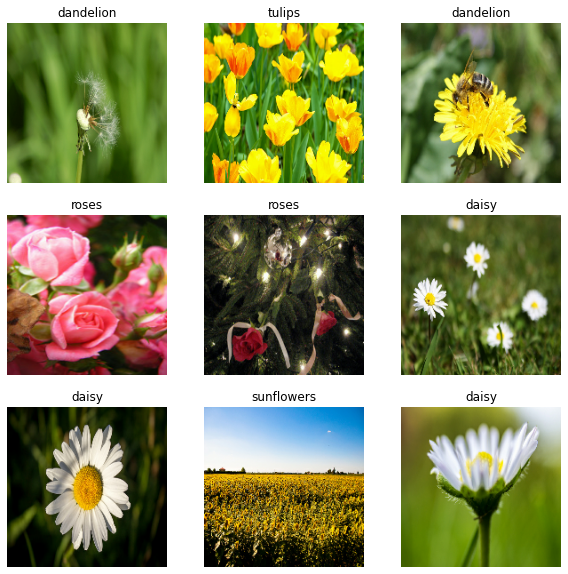

In [42]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # using prefetch for efficient model
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255) # pixels values are now in [0,1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98891795


## Model

In [45]:
model = keras.Sequential([
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [47]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 31s 341ms/step - loss: 1.2881 - accuracy: 0.4625 - val_loss: 1.0625 - val_accuracy: 0.5899
Epoch 2/15
92/92 [==============================] - 30s 323ms/step - loss: 0.9370 - accuracy: 0.6448 - val_loss: 1.0195 - val_accuracy: 0.5995
Epoch 3/15
92/92 [==============================] - 30s 328ms/step - loss: 0.7501 - accuracy: 0.7180 - val_loss: 1.0065 - val_accuracy: 0.6049
Epoch 4/15
92/92 [==============================] - 30s 327ms/step - loss: 0.5548 - accuracy: 0.8011 - val_loss: 1.0337 - val_accuracy: 0.6403
Epoch 5/15
92/92 [==============================] - 30s 328ms/step - loss: 0.3439 - accuracy: 0.8828 - val_loss: 1.0830 - val_accuracy: 0.6294
Epoch 6/15
92/92 [==============================] - 30s 328ms/step - loss: 0.2262 - accuracy: 0.9285 - val_loss: 1.3042 - val_accuracy: 0.6403
Epoch 7/15
92/92 [==============================] - 30s 331ms/step - loss: 0.1183 - accuracy: 0.9673 - val_loss: 1.5561 - val_accuracy: 0.6213

In [48]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

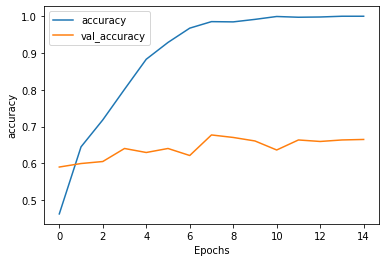

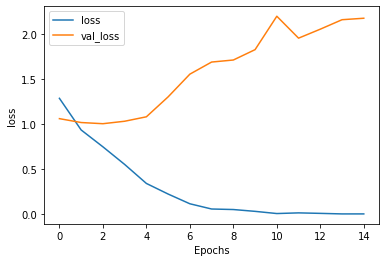

In [49]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

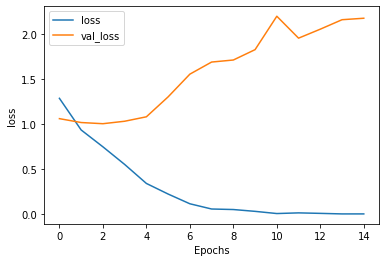

In [50]:
plot_graphs(history, 'loss') # Overfitting due to small data

## Data augmentation 

In [51]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

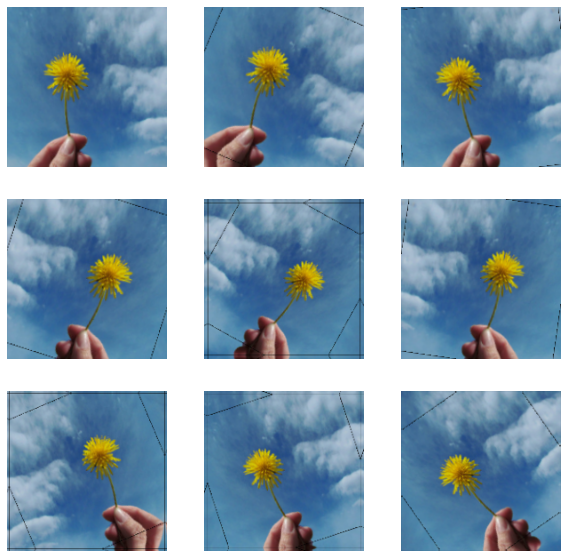

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [53]:
model = keras.Sequential([
  data_augmentation,
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [54]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [55]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 36s 394ms/step - loss: 1.4026 - accuracy: 0.3801 - val_loss: 1.1866 - val_accuracy: 0.5163
Epoch 2/15
92/92 [==============================] - 36s 388ms/step - loss: 1.1019 - accuracy: 0.5538 - val_loss: 1.0737 - val_accuracy: 0.5681
Epoch 3/15
92/92 [==============================] - 36s 389ms/step - loss: 0.9748 - accuracy: 0.6090 - val_loss: 1.0476 - val_accuracy: 0.5858
Epoch 4/15
92/92 [==============================] - 36s 395ms/step - loss: 0.8932 - accuracy: 0.6563 - val_loss: 0.9186 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 37s 402ms/step - loss: 0.8379 - accuracy: 0.6727 - val_loss: 0.9623 - val_accuracy: 0.6322
Epoch 6/15
92/92 [==============================] - 37s 403ms/step - loss: 0.7931 - accuracy: 0.6904 - val_loss: 1.1341 - val_accuracy: 0.5831
Epoch 7/15
92/92 [==============================] - 37s 405ms/step - loss: 0.7871 - accuracy: 0.6989 - val_loss: 0.8432 - val_accuracy: 0.6717

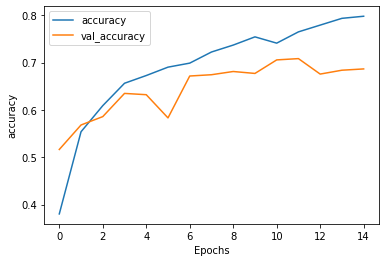

In [56]:
plot_graphs(history, 'accuracy')

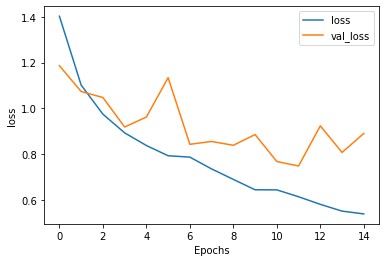

In [57]:
plot_graphs(history, 'loss')